In [1]:
from sklearn import feature_selection as fs
from matplotlib import pyplot as plt

import numpy as np, pandas as pd

In [2]:
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype_QTL.csv'
pheno = pd.read_csv(phenopath)

assert pheno.Clone.sum() == 0, "Clones present"
pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary,Genotyped,Clone,IRK7,RIC8,RHO,MAT
0,A_01,1.0,N,0.0,Yeast,0.0,0.0,0.0,A01,0,1.0,0.0,1.0,1.0
1,A_02,1.0,Y,0.0,Selfing,1.0,2.0,2.0,A02,0,0.0,1.0,1.0,0.0
2,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0,A03,0,0.0,0.0,0.0,0.0
3,A_04,1.0,L,0.0,Large Cell,1.0,1.0,1.0,A04,0,1.0,1.0,0.0,1.0
4,A_06,2.0,L,0.0,Large Cell,1.0,1.0,1.0,A06,0,1.0,1.0,0.0,1.0


In [3]:
phenotype = 'Quadrary'
pheno_chr14 = pheno[[phenotype,'IRK7','RIC8']]

In [4]:
n_rec = pheno_chr14[['IRK7','RIC8']].diff(axis=1).abs().sum().max()
n_rec

15.0

In [5]:
n_rec/(pheno_chr14.shape[0]-3)

0.21428571428571427

In [6]:
nboots = 1000
boots = []

while len(boots)<nboots:
    
    temp = pheno_chr14.sample(pheno_chr14.shape[0],replace=True).copy()
    miobs = fs.mutual_info_classif(temp.values,
                                   temp[phenotype],
                      discrete_features=True)
    
    boots.append(miobs)
    
boots = pd.DataFrame(boots,columns=['Entropy','IRK7','RIC8'])

In [7]:
varpos = dict(zip(['IRK7','RIC8'],[134798,388777]))

In [8]:
np.percentile(boots[['IRK7','RIC8']].T.idxmax().replace(varpos),99)

388777.0

In [9]:
boots.mean()

Entropy    1.216650
IRK7       0.209670
RIC8       0.581381
dtype: float64

In [121]:
pheno_chr14[['IRK7','RIC8']].corr(method='spearman')

,IRK7,RIC8
IRK7,1.000000,0.584349
RIC8,0.584349,1.000000


In [122]:
import scipy.stats as ss

In [123]:
ss.spearmanr(pheno_chr14.IRK7.values,pheno_chr14.RIC8.values)

SpearmanrResult(correlation=0.5843492038624621, pvalue=5.713014256949314e-08)

In [120]:
pheno_chr14[['IRK7','RIC8']].corr(method='pearson')

,IRK7,RIC8
IRK7,1.000000,0.584349
RIC8,0.584349,1.000000


In [113]:
obs = fs.mutual_info_classif(pheno_chr14.IRK7.values.reshape(-1,1),
                       pheno_chr14.RIC8.values,
                       discrete_features=True)
obs

array([0.18105694])

In [105]:
perms = np.concatenate([fs.mutual_info_classif(np.random.permutation(pheno_chr14.IRK7.values.reshape(-1,1)),
                       pheno_chr14.RIC8.values,
                       discrete_features=True) for i in range(1000)])

In [111]:
np.sum(perms > obs)/len(perms)

0.0

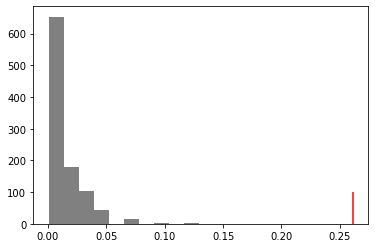

In [112]:
plt.hist(perms/np.log(2),color='grey');
plt.vlines(obs/np.log(2),0,100,color='r');